# **LAB II: Dynamic Time Warping Based Anomaly Detection For Industrial Control System**
**Souad Asroubi**

#**1. Import libraries**

In [1]:
pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512581 sha256=fbefa33b591fcf05fcdb337ef73d7c474fa697a26e4b68784356f9fcd9966e67
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input,Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,accuracy_score,classification_report
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial.distance import euclidean
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,r2_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **2. Dataset Loading**

In [2]:
dataset_path_normal = '/content/drive/My Drive/swat/SWaT_Dataset_Normal_v0.csv'
dataset_path_attack = '/content/drive/My Drive/swat/SWaT_Dataset_Attack_v0.csv'

In [6]:
SWaT_normal = pd.read_csv(dataset_path_normal)
SWaT_attack = pd.read_csv(dataset_path_attack)

data = pd.concat([SWaT_normal, SWaT_attack])

In [8]:
print(data.shape)
data.head()

(946719, 53)


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:00:00 PM,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2,22/12/2015 4:00:02 PM,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
3,22/12/2015 4:00:03 PM,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
4,22/12/2015 4:00:04 PM,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 946719 entries, 0 to 449918
Data columns (total 53 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      946719 non-null  object 
 1   FIT101         946719 non-null  float64
 2   LIT101         946719 non-null  float64
 3   MV101          946719 non-null  int64  
 4   P101           946719 non-null  int64  
 5   P102           946719 non-null  int64  
 6   AIT201         946719 non-null  float64
 7   AIT202         946719 non-null  float64
 8   AIT203         946719 non-null  float64
 9   FIT201         946719 non-null  float64
 10  MV201          946719 non-null  int64  
 11  P201           946719 non-null  int64  
 12  P202           946719 non-null  int64  
 13  P203           946719 non-null  int64  
 14  P204           946719 non-null  int64  
 15  P205           946719 non-null  int64  
 16  P206           946719 non-null  int64  
 17  DPIT301        946719 non-nul

#**3. Visualization**

In [6]:
data['Normal/Attack'].unique()

array(['Normal', 'Attack', 'A ttack'], dtype=object)

In [7]:
# Remove extra spaces
data['Normal/Attack'] = data['Normal/Attack'].str.replace(' ', '')

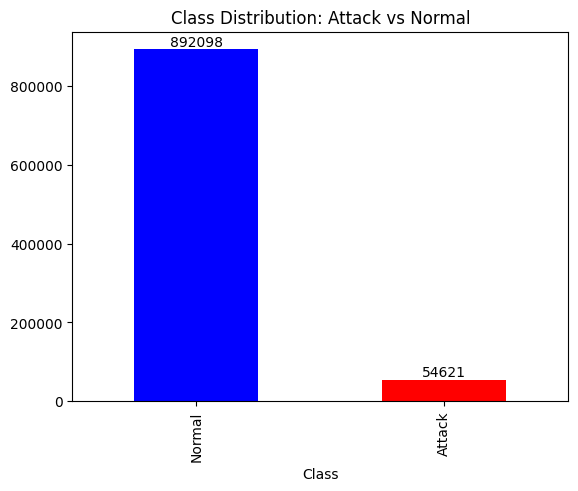

In [10]:
# Class distribution (Normal vs. Attack) in SWaT
class_distribution = data['Normal/Attack'].value_counts()
fig, ax = plt.subplots()
bar_plot = class_distribution.plot(kind='bar', color=['blue', 'red'], ax=ax)

plt.title('Class Distribution: Attack vs Normal')
plt.xlabel('Class')
for i, count in enumerate(class_distribution):
    ax.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [11]:
# Converting the Timestamp to a datetime and set it as an index
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data= data.set_index('Timestamp')

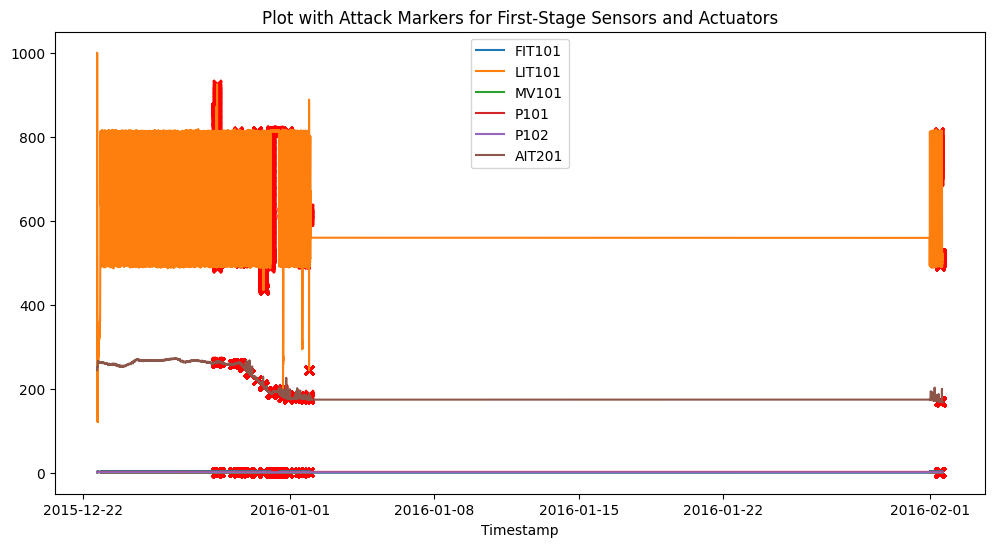

In [12]:
attack_data = data[data['Normal/Attack'] == 'Attack']

# List of all sensors and actuators in the first stage
first_stage_features = ['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201']

plt.figure(figsize=(12, 6))
for feature in first_stage_features:
    plt.plot(data.index, data[feature], label=feature)
    plt.scatter(attack_data.index, attack_data[feature], color='red', marker='x', label=None)
plt.legend()
plt.xlabel('Timestamp')
plt.title('Plot with Attack Markers for First-Stage Sensors and Actuators')
plt.show()

#**4. Data Preprocessing**

##Data Cleaning

In [13]:
# Remove duplicate rows
data.drop_duplicates(inplace=True)

In [14]:
# Drop missing values
data.dropna(inplace=True)

data.shape

(928898, 52)

In [15]:
data.nunique()

FIT101            3953
LIT101           12162
MV101                3
P101                 2
P102                 2
AIT201            2338
AIT202            1763
AIT203            6868
FIT201            4989
MV201                3
P201                 2
P202                 1
P203                 2
P204                 2
P205                 2
P206                 2
DPIT301           5180
FIT301            8281
LIT301           11966
MV301                3
MV302                3
MV303                3
MV304                3
P301                 2
P302                 2
AIT401              37
AIT402            4127
FIT401             968
LIT401           15141
P401                 1
P402                 2
P403                 2
P404                 1
UV401                2
AIT501            1724
AIT502            3470
AIT503            1123
AIT504             565
FIT501            1027
FIT502            1560
FIT503             499
FIT504             289
P501                 2
P502       

In [16]:
data = data.loc[:, data.nunique() > 1]

In [17]:
 data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 928898 entries, 2015-12-22 16:00:00 to 2016-02-01 14:59:59
Data columns (total 46 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   FIT101         928898 non-null  float64
 1   LIT101         928898 non-null  float64
 2   MV101          928898 non-null  int64  
 3   P101           928898 non-null  int64  
 4   P102           928898 non-null  int64  
 5   AIT201         928898 non-null  float64
 6   AIT202         928898 non-null  float64
 7   AIT203         928898 non-null  float64
 8   FIT201         928898 non-null  float64
 9   MV201          928898 non-null  int64  
 10  P201           928898 non-null  int64  
 11  P203           928898 non-null  int64  
 12  P204           928898 non-null  int64  
 13  P205           928898 non-null  int64  
 14  P206           928898 non-null  int64  
 15  DPIT301        928898 non-null  float64
 16  FIT301         928898 non-null  float64


In [18]:
# Convert "Normal/Attack" column to binary
data['Normal/Attack'] = data['Normal/Attack'].apply(lambda x: 1 if x == 'Attack' else 0)


In [19]:
X = data.drop('Normal/Attack', axis=1)
y= data['Normal/Attack']
y = y.reset_index(drop=True)

In [20]:
# Numerical and categorical features
numerical_features = []
categorical_features = []

for column in X.columns:
    unique_values = X[column].nunique()
    if unique_values > 10:
        numerical_features.append(column)
    else:
        categorical_features.append(column)

In [21]:
numerical_features

['FIT101',
 'LIT101',
 'AIT201',
 'AIT202',
 'AIT203',
 'FIT201',
 'DPIT301',
 'FIT301',
 'LIT301',
 'AIT401',
 'AIT402',
 'FIT401',
 'LIT401',
 'AIT501',
 'AIT502',
 'AIT503',
 'AIT504',
 'FIT501',
 'FIT502',
 'FIT503',
 'FIT504',
 'PIT501',
 'PIT502',
 'PIT503',
 'FIT601']

In [22]:
categorical_features

['MV101',
 'P101',
 'P102',
 'MV201',
 'P201',
 'P203',
 'P204',
 'P205',
 'P206',
 'MV301',
 'MV302',
 'MV303',
 'MV304',
 'P301',
 'P302',
 'P402',
 'P403',
 'UV401',
 'P501',
 'P602']

In [23]:
numerical_data = data[numerical_features]
categorical_data = data[categorical_features]

# Min-Max scaling for numerical features
scaler = MinMaxScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)
numerical_data_scaled_df = pd.DataFrame(numerical_data_scaled, columns=numerical_data.columns)

# One-hot encoding for categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(categorical_data)

categorical_feature_names = encoder.get_feature_names_out(categorical_data.columns)
categorical_data_encoded = encoder.transform(categorical_data)
categorical_data_encoded_df = pd.DataFrame(categorical_data_encoded, columns=categorical_feature_names)
preprocessed_data = pd.concat([numerical_data_scaled_df, categorical_data_encoded_df], axis=1)

In [24]:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928898 entries, 0 to 928897
Data columns (total 51 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   FIT101   928898 non-null  float64
 1   LIT101   928898 non-null  float64
 2   AIT201   928898 non-null  float64
 3   AIT202   928898 non-null  float64
 4   AIT203   928898 non-null  float64
 5   FIT201   928898 non-null  float64
 6   DPIT301  928898 non-null  float64
 7   FIT301   928898 non-null  float64
 8   LIT301   928898 non-null  float64
 9   AIT401   928898 non-null  float64
 10  AIT402   928898 non-null  float64
 11  FIT401   928898 non-null  float64
 12  LIT401   928898 non-null  float64
 13  AIT501   928898 non-null  float64
 14  AIT502   928898 non-null  float64
 15  AIT503   928898 non-null  float64
 16  AIT504   928898 non-null  float64
 17  FIT501   928898 non-null  float64
 18  FIT502   928898 non-null  float64
 19  FIT503   928898 non-null  float64
 20  FIT504   928898 non-null  

In [25]:
preprocessed_data.head(3)

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV303_2,MV304_1,MV304_2,P301_2,P302_2,P402_2,P403_2,UV401_2,P501_2,P602_2
0,0.894987,0.160292,0.730144,0.732892,0.073596,0.874201,0.462186,0.940694,0.182199,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.890230,0.159845,0.730144,0.732892,0.073596,0.873249,0.462186,0.940371,0.182199,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.883848,0.159533,0.730144,0.732892,0.073596,0.872796,0.463182,0.939886,0.182199,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Save preprocessed data to drive
preprocessed_data.to_csv('/content/drive/My Drive/swat/preprocessed_data.csv', index=False)

**Loading preprocessed data for DTW**

In [ ]:
SWaT_preprocessed = pd.read_csv('/content/drive/My Drive/swat/preprocessed_data.csv')

In [ ]:
sensors=['FIT101','LIT101']

In [ ]:
X=SWaT_preprocessed

#**Applying Data Time WArping (DTW)**

In [ ]:
from scipy.spatial.distance import euclidean
from joblib import Parallel, delayed
from fastdtw import fastdtw

In [ ]:
sampled_data = X.sample(n=5000, random_state=42)
sampled_data = sampled_data.astype(np.float64)

In [ ]:
sampled_data_dtw=sampled_data[sensors]

In [ ]:
sampled_data_dtw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 693046 to 870610
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FIT101  5000 non-null   float64
 1   LIT101  5000 non-null   float64
dtypes: float64(2)
memory usage: 117.2 KB


In [ ]:
columns_for_dtw = sampled_data.columns

In [ ]:
def calculate_dtw_distance(seq1, seq2):
    distance, _ = fastdtw(seq1, seq2)
    return distance

In [ ]:
def calculate_dtw_parallel(row, df, columns_for_dtw):
    current_seq = row[columns_for_dtw].values.flatten()
    distances = []

    for idx, r in df.iterrows():
        if row.name != idx:
            compared_seq = r[columns_for_dtw].values.flatten()
            distance = calculate_dtw_distance(current_seq, compared_seq)
            distances.append(distance)

    min_distance = min(distances) if distances else None
    return min_distance

In [ ]:
num_cores = -1
dtw_distances = Parallel(n_jobs=num_cores)(
    delayed(calculate_dtw_parallel)(row, sampled_data, columns_for_dtw) for _, row in sampled_data.iterrows()
)

In [ ]:
dtw_distances

[0.07605044579640977,
 0.0495477329171756,
 0.37347412621044773,
 0.008202577396307854,
 0.17133095145771507,
 0.03603869489792816,
 0.05144447575660238,
 0.1330630470737353,
 1.46712391579157,
 0.07944405191033709,
 0.07969480326481905,
 0.04379260319018782,
 0.09780761933239872,
 0.023940932479920574,
 0.14980362178859066,
 0.05315864787791641,
 0.08556108784293237,
 0.06158766428291798,
 0.05931444876584384,
 0.06045459173901696,
 0.070385593403607,
 0.05603955738511841,
 0.13206158318372524,
 0.06815585208096682,
 0.0647855349301397,
 0.055711424794132214,
 0.05371611055964433,
 0.05710452389992782,
 0.07012202955572412,
 0.09666219294831709,
 0.12114441213388129,
 0.06388290783140196,
 0.03603869489792816,
 0.05277800495791299,
 0.08859550138752052,
 0.07762288690802521,
 0.3268923494362833,
 0.1259215579371138,
 0.15890952499872105,
 0.028012091359205182,
 0.08667537157965176,
 0.08993224373638381,
 0.10353057393883361,
 0.10868461079802116,
 0.05810917813797489,
 0.1526361743924

In [ ]:
sampled_data['dtw_distances'] = dtw_distances

In [ ]:
# Save sampled_data + dtw distances to drive
sampled_data.to_csv('/content/drive/My Drive/swat/sampled_data_with_dtw.csv', index=False)
sampled_data.to_excel('/content/drive/My Drive/swat/sampled_data_with_dtw.xlsx', index=False)

In [ ]:
sampled_data.head(3)

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV304_2,P301_2,P302_2,P402_2,P403_2,UV401_2,P501_2,P602_2,Normal/Attack_1,dtw_distances
693046,0.906359,0.432890,0.283962,0.841836,0.152735,0.864228,0.441343,0.927162,0.670225,0.999677,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.076050
916789,0.000000,0.456637,0.018093,0.900598,0.021079,0.000000,0.040407,0.000000,0.822014,0.999645,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.049548
292515,0.876537,0.774854,0.972707,0.812241,0.116664,0.000000,0.050010,0.000000,0.821339,0.999677,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.373474


#**Isolation Forest using Sampled Data without DTW:**

In [7]:
# Load sampled_data + dtw distances from drive
sampled_data = pd.read_csv('/content/drive/My Drive/swat/sampled_data_with_dtw.csv')

In [32]:
#uncomment this to remove DTW distance
X_sampled = sampled_data.drop(columns=['Normal/Attack_1', 'dtw_distances']) #removing dtw distance feature
y_sampled = sampled_data['Normal/Attack_1']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

In [54]:
#uncomment this to use DTW distance
X_sampled = sampled_data.drop(columns=['Normal/Attack_1'])
y_sampled = sampled_data['Normal/Attack_1']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

In [ ]:
iso_model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.01),
                             max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
iso_model.fit(X_train_s)

IsolationForest(contamination=0.01, n_jobs=-1, random_state=42)

In [ ]:
iso_predictions = iso_model.predict(X_test_s)

iso_binary_predictions = [1 if pred == -1 else 0 for pred in iso_predictions]

iso_true_labels = y_test_s
iso_predicted_labels = iso_binary_predictions

##without DTW

In [ ]:
accuracy = accuracy_score(iso_true_labels, iso_predicted_labels)
confusion = confusion_matrix(iso_true_labels, iso_predicted_labels)
precision = precision_score(iso_true_labels, iso_predicted_labels)
recall = recall_score(iso_true_labels, iso_predicted_labels)
f1 = f1_score(iso_true_labels, iso_predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:")
print(classification_report(iso_true_labels, iso_predicted_labels))

Accuracy: 0.924
Confusion Matrix:
[[922   6]
 [ 70   2]]
Precision: 0.25
Recall: 0.027777777777777776
F1 Score: 0.049999999999999996
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       928
         1.0       0.25      0.03      0.05        72

    accuracy                           0.92      1000
   macro avg       0.59      0.51      0.51      1000
weighted avg       0.88      0.92      0.89      1000



##Using DTW

In [ ]:
#First ==> run isolation forest again by adding the dtw distance
accuracy = accuracy_score(iso_true_labels, iso_predicted_labels)
confusion = confusion_matrix(iso_true_labels, iso_predicted_labels)

precision = precision_score(iso_true_labels, iso_predicted_labels)
recall = recall_score(iso_true_labels, iso_predicted_labels)
f1 = f1_score(iso_true_labels, iso_predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:")
print(classification_report(iso_true_labels, iso_predicted_labels))

Accuracy: 0.927
Confusion Matrix:
[[923   5]
 [ 68   4]]
Precision: 0.4444444444444444
Recall: 0.05555555555555555
F1 Score: 0.09876543209876543
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       928
         1.0       0.44      0.06      0.10        72

    accuracy                           0.93      1000
   macro avg       0.69      0.53      0.53      1000
weighted avg       0.90      0.93      0.90      1000



#Autoencoder using Sampled data

In [55]:
input_shape = X_train_s.shape[1]
input_data = Input(shape=(input_shape,))
encoded = Dense(32, activation="relu")(input_data)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.5)(encoded)

# Decoding layer
decoded = Dense(input_shape, activation='sigmoid')(encoded)

autoencoder = Model(input_data, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

autoencoder_train=autoencoder.fit(X_train_s, X_train_s,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_s, X_test_s),callbacks=[early_stopping],verbose=1)

y_pred = autoencoder.predict(X_test_s)
mse = np.mean(np.power(X_test_s - y_pred, 2), axis=1)
y_predictions = y_pred[:, 0]

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 52)]              0         
                                                                 
 dense_8 (Dense)             (None, 32)                1696      
                                                                 
 batch_normalization_4 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 52)                1716      
                                                                 
Total params: 3540 (13.83 KB)
Trainable params: 3476 (13.58 KB)
Non-trainable params: 64 (256.00 Byte)
______________________

In [53]:
threshold = np.percentile(mse, 95.5)

y_pred = (mse > threshold).astype(int)

accuracy = accuracy_score(y_test_s, y_pred)
conf_matrix = confusion_matrix(y_test_s, y_pred)
precision = precision_score(y_test_s, y_pred)
recall = recall_score(y_test_s, y_pred)
f1 = f1_score(y_test_s, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Classification Report:")
print(classification_report(y_test_s, y_pred))

Accuracy: 0.903
Confusion Matrix:
[[893  35]
 [ 62  10]]
Precision: 0.2222222222222222
Recall: 0.1388888888888889
F1-score: 0.17094017094017094
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       928
         1.0       0.22      0.14      0.17        72

    accuracy                           0.90      1000
   macro avg       0.58      0.55      0.56      1000
weighted avg       0.88      0.90      0.89      1000



###AutoEncoder using DTW

In [78]:
#First ==> run Autoencoder again after adding the dtw distance
threshold = np.percentile(mse, 95.5)
y_pred = (mse > threshold).astype(int)

accuracy = accuracy_score(y_test_s, y_pred)
conf_matrix = confusion_matrix(y_test_s, y_pred)
precision = precision_score(y_test_s, y_pred)
recall = recall_score(y_test_s, y_pred)
f1 = f1_score(y_test_s, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Classification Report:")
print(classification_report(y_test_s, y_pred))

Accuracy: 0.963
Confusion Matrix:
[[923   5]
 [ 32  40]]
Precision: 0.8888888888888888
Recall: 0.5555555555555556
F1-score: 0.6837606837606838
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       928
         1.0       0.89      0.56      0.68        72

    accuracy                           0.96      1000
   macro avg       0.93      0.78      0.83      1000
weighted avg       0.96      0.96      0.96      1000



#**BASELINES : AutoEncoder and Isolation forest** (Using all the data)

###Split :Train/Test

In [26]:
input_shape = df_train.shape[1]

705962

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (743118, 45)
Test data shape: (185780, 45)


In [28]:
X_train.shape

(743118, 45)

In [29]:
X_test.shape

(185780, 45)

In [30]:
df_train = X.iloc[:700000, :]
df_test = X.iloc[700000:, :]
target_train = y.iloc[:700000]
target_test = y.iloc[700000:]

print("Training data shape:", df_train.shape)
print("Test data shape:", df_test.shape)

Training data shape: (700000, 45)
Test data shape: (228898, 45)


##**Baseline 1 : Autoencoder** (With All Data)

In [ ]:
input_shape = df_train.shape[1]

In [ ]:
# Define the encoding layer
input_data = Input(shape=(input_shape,))
encoded = Dense(32, activation="relu")(input_data)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.5)(encoded)

# Decoding layer
decoded = Dense(input_shape, activation='sigmoid')(encoded)

autoencoder = Model(input_data, decoded)

In [ ]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 51)]              0         
                                                                 
 dense_20 (Dense)            (None, 32)                1664      
                                                                 
 batch_normalization_4 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 51)                1683      
                                                                 
Total params: 3475 (13.57 KB)
Trainable params: 3411 (13.32 KB)
Non-trainable params: 64 (256.00 Byte)
______________________

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [ ]:
autoencoder_train=autoencoder.fit(df_train, df_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(df_test, df_test),callbacks=[early_stopping],verbose=1)

Epoch 1/100
2735/2735 [==============================] - 11s 4ms/step - loss: 0.0199 - val_loss: 0.0519
Epoch 2/100
2735/2735 [==============================] - 9s 3ms/step - loss: 0.0071 - val_loss: 0.0379
Epoch 3/100
2735/2735 [==============================] - 12s 4ms/step - loss: 0.0063 - val_loss: 0.0265
Epoch 4/100
2735/2735 [==============================] - 10s 4ms/step - loss: 0.0059 - val_loss: 0.0207
Epoch 5/100
2735/2735 [==============================] - 10s 4ms/step - loss: 0.0056 - val_loss: 0.0190
Epoch 6/100
2735/2735 [==============================] - 11s 4ms/step - loss: 0.0054 - val_loss: 0.0211
Epoch 7/100
2735/2735 [==============================] - 8s 3ms/step - loss: 0.0053 - val_loss: 0.0214
Epoch 8/100
2735/2735 [==============================] - 11s 4ms/step - loss: 0.0052 - val_loss: 0.0197
Epoch 9/100
2735/2735 [==============================] - 10s 4ms/step - loss: 0.0052 - val_loss: 0.0195
Epoch 10/100
2735/2735 [==============================] - 10s 4ms/

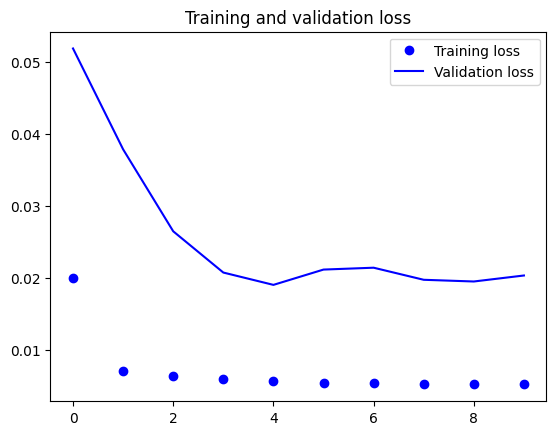

In [ ]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(10)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
y_pred = autoencoder.predict(df_test)


7154/7154 [==============================] - 15s 2ms/step


In [ ]:
mse = np.mean(np.power(df_test - y_pred, 2), axis=1)

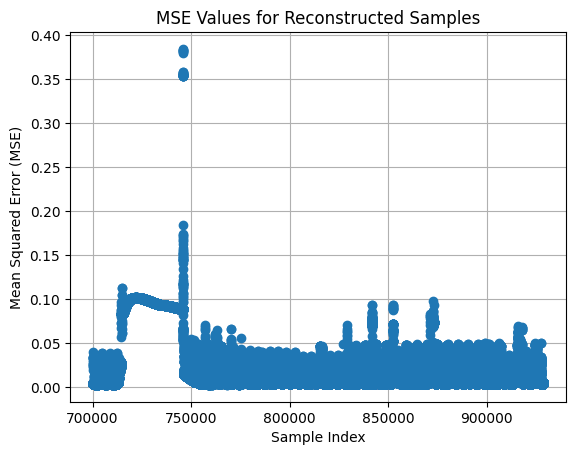

In [ ]:
plt.plot(mse, marker='o', linestyle='')
plt.xlabel('Sample Index')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Values for Reconstructed Samples')
plt.grid(True)
plt.show()

In [ ]:
y_predictions = y_pred[:, 0]

In [ ]:
threshold = np.percentile(mse, 85)

y_pred = (mse > threshold).astype(int)

accuracy = accuracy_score(target_test, y_pred)
conf_matrix = confusion_matrix(target_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.951423778276787
Confusion Matrix:
[[185120   1676]
 [  9443  32659]]


In [ ]:
threshold

0.03126554320373542

In [ ]:
precision = precision_score(target_test, y_pred)
recall = recall_score(target_test, y_pred)
f1 = f1_score(target_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Classification Report:")
print(classification_report(target_test, y_pred))

Precision: 0.9511868355905053
Recall: 0.7757113676309914
F1-score: 0.8545337990763635
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    186796
           1       0.95      0.78      0.85     42102

    accuracy                           0.95    228898
   macro avg       0.95      0.88      0.91    228898
weighted avg       0.95      0.95      0.95    228898



In [ ]:
thresholds = np.linspace(min(mse), max(mse), num=100)
precision_list, recall_list, f1_list = [], [], []

# Calculate precision, recall, and F1-score for each threshold
for threshold in thresholds:
    predicted_anomalies = (mse > threshold).astype(int)
    precision = precision_score(target_test, predicted_anomalies)
    recall = recall_score(target_test, predicted_anomalies)
    f1 = f1_score(target_test, predicted_anomalies)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

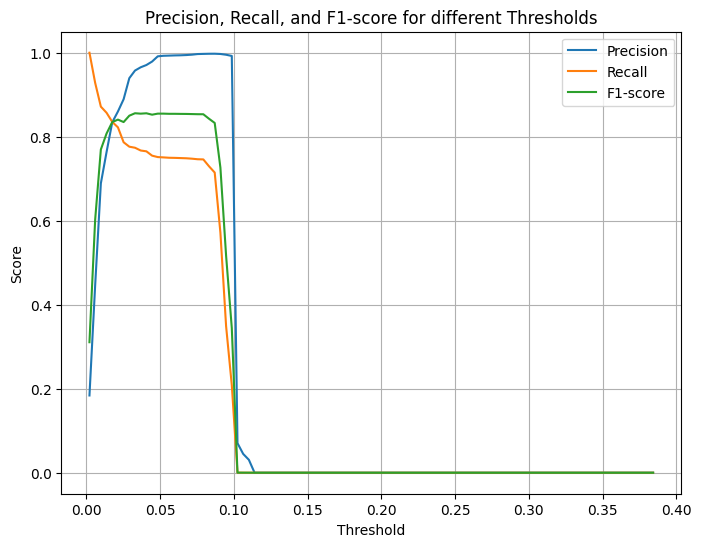

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.plot(thresholds, f1_list, label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision, Recall, and F1-score for different Thresholds')
plt.grid(True)
plt.show()

In [ ]:
max(f1_list)

0.8558930166570332

## **Baseline 2 : Isolation Forest**


In [ ]:
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.01),
                             max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

In [ ]:
model.fit(df_train)

IsolationForest(contamination=0.01, n_jobs=-1, random_state=42)

In [ ]:
predictions = model.predict(df_test)

binary_predictions = [1 if pred == -1 else 0 for pred in predictions]

true_labels = target_test
predicted_labels = binary_predictions

In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Accuracy: 0.9459453555732248
Confusion Matrix:
[[184552   2244]
 [ 10129  31973]]
Precision: 0.9344185638717597
Recall: 0.759417604864377
F1 Score: 0.8378778547936949
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    186796
           1       0.93      0.76      0.84     42102

    accuracy                           0.95    228898
   macro avg       0.94      0.87      0.90    228898
weighted avg       0.95      0.95      0.94    228898

